<a href="https://colab.research.google.com/github/peremartra/Tailoring-LLM-Architectures/blob/CH06/CH06/CH06_NB01_Layer_Mapping_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tailoring LLM Architectures**
## **Chapter 6: Layer Mapping Experiments**

### **Notebook 1: Solving the Depth Mismatch Problem**
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

---

**Colab Environment:** GPU T4
- **Model:** Qwen/Qwen2.5-0.5B (Teacher) + depth-pruned version (Student, 20 layers)
- **Expected Runtime:** 25-30 minutes

---

**What we'll accomplish:**
- Demonstrate the depth mismatch problem when computing L_Hidden with different layer counts
- Implement and compare two layer mapping strategies (Uniform vs Last-Layer)
- Show that Last-Layer mapping is superior (~2% improvement)
- Demonstrate that feature alignment provides crucial +4-5% recovery beyond logits-only KD
- Visualize the convergence of internal representations during training

## Section 0: Environment & Dependencies

In [1]:
# Install required packages
!pip install -q transformers accelerate datasets
!pip install -q optipfair  # For creating pruned model on-the-fly
!pip install -q matplotlib seaborn tqdm
!pip install -q lm_eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.7/358.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [3]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [4]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
    evaluate_metrics,  # Loss & Perplexity
    clear_gpu_cache
)

✅ utils.py downloaded successfully


## Section 1: Load Models and Create Pruned Student

In [5]:
MODEL_NAME = "google/gemma-3-270m"

print(f"Loading Teacher model: {MODEL_NAME}")
teacher_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# Freeze teacher (we never update it)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Print architecture info
n_teacher_layers = len(teacher_model.model.layers)
hidden_dim = teacher_model.config.hidden_size

print(f"\n{'='*60}")
print(f"Teacher Model: {MODEL_NAME}")
print(f"{'='*60}")
print(f"Total layers: {n_teacher_layers}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Total parameters: {teacher_model.num_parameters():,}")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1e9:.2f} GB")
print(f"{'='*60}\n")

Loading Teacher model: google/gemma-3-270m


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]


Teacher Model: google/gemma-3-270m
Total layers: 18
Hidden dimension: 640
Total parameters: 268,098,176
Memory footprint: 0.54 GB



In [6]:
import optipfair as opf

print("Creating Student model with depth pruning...")

# IMPORTANT: Use deepcopy to avoid modifying the original model
student_model = deepcopy(teacher_model)

# Apply depth pruning: remove last 4 layers
LAYERS_TO_REMOVE = 4
student_model = opf.prune_model_depth(
    model=student_model,
    num_layers_to_remove=LAYERS_TO_REMOVE,
    layer_selection_method="last",
    show_progress=True,
)

# IMPORTANT: Unfreeze student parameters!
# The deepcopy inherited requires_grad=False from the frozen teacher
for param in student_model.parameters():
    param.requires_grad = True

# Get student info
n_student_layers = len(student_model.model.layers)

print(f"\n{'='*60}")
print(f"Student Model (Depth Pruned)")
print(f"{'='*60}")
print(f"Total layers: {n_student_layers} (removed {LAYERS_TO_REMOVE})")
print(f"Hidden dimension: {hidden_dim} (unchanged)")
print(f"Total parameters: {student_model.num_parameters():,}")
print(f"{'='*60}\n")

print(f"✓ Student has {n_student_layers} layers vs Teacher's {n_teacher_layers} layers")
print(f"✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping")
print(f"✓ Student parameters unfrozen and ready for training")

Creating Student model with depth pruning...


Removing layers: 100%|██████████| 18/18 [00:00<00:00, 271573.64it/s]


Student Model (Depth Pruned)
Total layers: 14 (removed 4)
Hidden dimension: 640 (unchanged)
Total parameters: 245,803,648

✓ Student has 14 layers vs Teacher's 18 layers
✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping
✓ Student parameters unfrozen and ready for training


## Section 2: Prepare Training Dataset

In [7]:
# Load SlimPajama dataset in streaming mode for efficiency
print("Loading SlimPajama-627B dataset...")
dataset = load_dataset(
    "cerebras/SlimPajama-627B",
    split="train",
    streaming=True
)

# Take a representative subset for our recovery process
RECOVERY_SAMPLES = 10000
print(f"Selecting {RECOVERY_SAMPLES:,} samples for knowledge recovery...")

# Use streaming dataset's take method
distillation_dataset = dataset.take(RECOVERY_SAMPLES)
print(f"✓ Streaming dataset ready: {RECOVERY_SAMPLES:,} samples")

Loading SlimPajama-627B dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/59166 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31428 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31411 [00:00<?, ?it/s]

Selecting 10,000 samples for knowledge recovery...
✓ Streaming dataset ready: 10,000 samples


In [8]:
# # ALTERNATIVE DATASET: Cosmopedia
# # Uncomment this cell to use Cosmopedia instead of SlimPajama
#
# print("Loading Cosmopedia dataset...")
# dataset_name = "HuggingFaceTB/cosmopedia"
# subsets = ["stories", "wikihow", "openstax", "web_samples_v1"]
# samples_per_subset = 3750
# num_samples = samples_per_subset * len(subsets)  # 15000 total
#
# print(f"Loading {len(subsets)} subsets with {samples_per_subset:,} samples each...")
#
# all_samples = []
# for subset in subsets:
#     print(f"  Loading {subset}...")
#     subset_data = load_dataset(dataset_name, subset, split="train", streaming=True)
#     subset_samples = list(subset_data.take(samples_per_subset))
#     all_samples.extend(subset_samples)
#     print(f"    ✓ {len(subset_samples):,} samples from {subset}")
#
# print(f"✓ Total samples loaded: {len(all_samples):,}")
#
# from datasets import Dataset
# distillation_dataset = Dataset.from_dict({'text': [s['text'] for s in all_samples]})
# print(f"✓ Cosmopedia dataset ready: {len(distillation_dataset):,} samples")

In [9]:
MAX_LENGTH = 512

def tokenize_function(examples):
    """Tokenize text samples for training"""
    texts = examples['text'] if isinstance(examples, dict) else examples
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

print(f"✓ Tokenization function ready (max_length={MAX_LENGTH})")

✓ Tokenization function ready (max_length=512)


In [10]:
print("Preparing DataLoader...")

# Convert streaming dataset to list
print("  Converting streaming dataset to list...")
dataset_list = list(distillation_dataset)
texts = [item['text'] for item in dataset_list]

print(f"  Tokenizing {len(texts):,} samples...")
tokenized_data = []
batch_size = 1000
for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
    batch_texts = texts[i:i+batch_size]
    batch_tokens = tokenizer(
        batch_texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    tokenized_data.append(batch_tokens)

# Combine all batches
input_ids = torch.cat([batch['input_ids'] for batch in tokenized_data], dim=0)
attention_mask = torch.cat([batch['attention_mask'] for batch in tokenized_data], dim=0)

# Create TensorDataset and DataLoader
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, attention_mask)

BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"\n✓ DataLoader ready:")
print(f"  Total samples: {len(train_dataset):,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total batches: {len(train_dataloader):,}")

Preparing DataLoader...
  Converting streaming dataset to list...
  Tokenizing 10,000 samples...


Tokenizing:   0%|          | 0/10 [00:00<?, ?it/s]


✓ DataLoader ready:
  Total samples: 10,000
  Batch size: 2
  Total batches: 5,000


## Section 3: Implement Layer Mapping Strategies

Testing layer mapping strategies:
Student layers: 14
Teacher layers: 18

✓ Uniform mapping: [0, 1, 2, 3, 5]... (showing first 5)
✓ Last-layer mapping: [4, 5, 6, 7, 8]... (showing first 5)


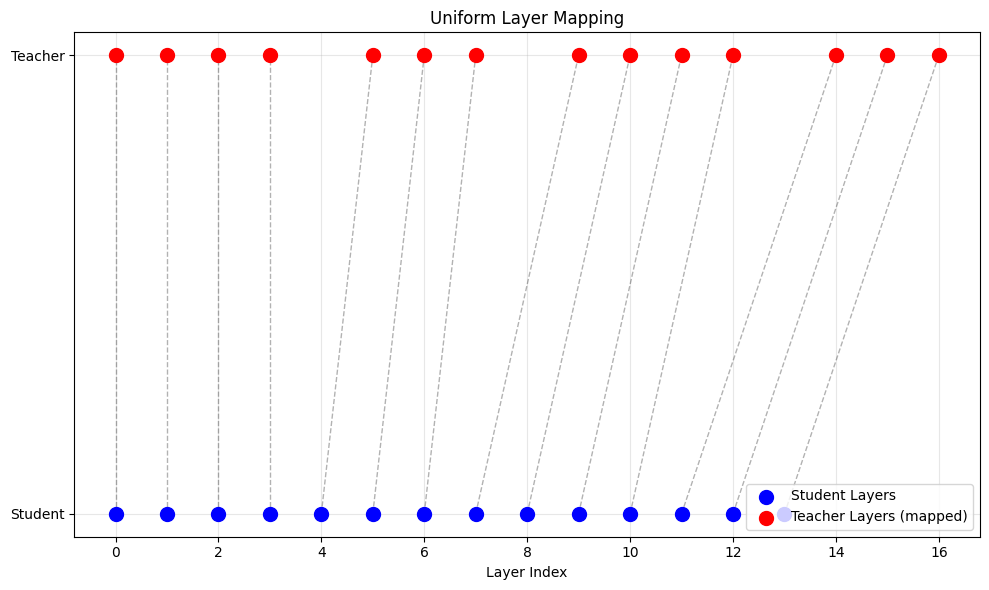


Uniform Layer Mapping:
Student Layer → Teacher Layer
──────────────────────────────
Layer  0 → Layer  0
Layer  1 → Layer  1
Layer  2 → Layer  2
Layer  3 → Layer  3
Layer  4 → Layer  5
Layer  5 → Layer  6
Layer  6 → Layer  7
Layer  7 → Layer  9
Layer  8 → Layer 10
Layer  9 → Layer 11
Layer 10 → Layer 12
Layer 11 → Layer 14
Layer 12 → Layer 15
Layer 13 → Layer 16


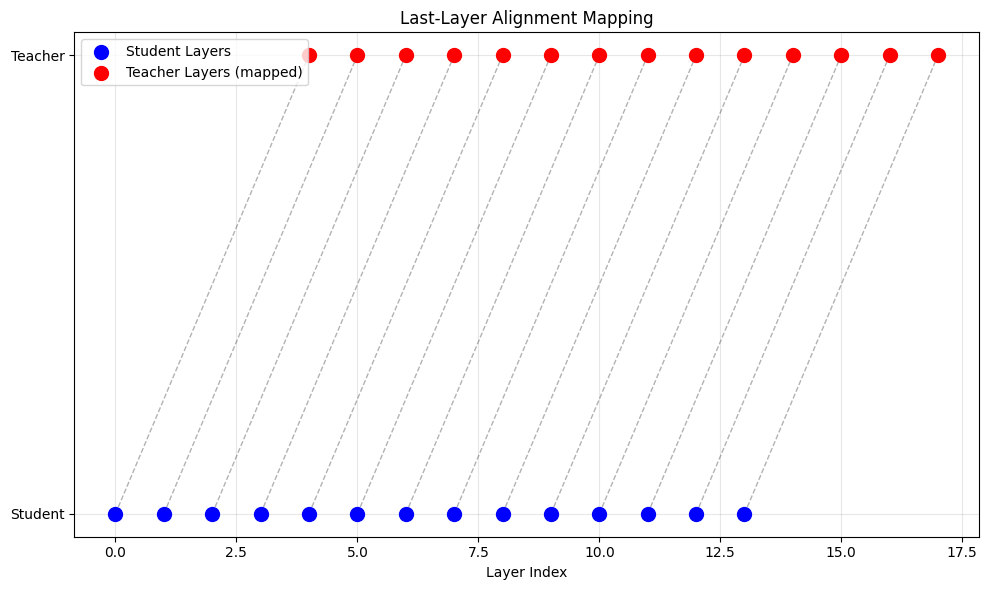


Last-Layer Alignment Mapping:
Student Layer → Teacher Layer
──────────────────────────────
Layer  0 → Layer  4
Layer  1 → Layer  5
Layer  2 → Layer  6
Layer  3 → Layer  7
Layer  4 → Layer  8
Layer  5 → Layer  9
Layer  6 → Layer 10
Layer  7 → Layer 11
Layer  8 → Layer 12
Layer  9 → Layer 13
Layer 10 → Layer 14
Layer 11 → Layer 15
Layer 12 → Layer 16
Layer 13 → Layer 17


In [11]:
def create_layer_map_uniform(n_student, n_teacher):
    """
    Uniform layer mapping: Distribute student layers proportionally across teacher layers

    Args:
        n_student: Number of student layers
        n_teacher: Number of teacher layers

    Returns:
        List of teacher layer indices for each student layer
    """
    teacher_indices = []
    for i in range(n_student):
        teacher_idx = int(i * n_teacher / n_student)
        teacher_indices.append(teacher_idx)
    return teacher_indices


def create_layer_map_last(n_student, n_teacher):
    """
    Last-layer alignment: Map student layers to the deepest teacher layers

    Args:
        n_student: Number of student layers
        n_teacher: Number of teacher layers

    Returns:
        List of teacher layer indices for each student layer
    """
    offset = n_teacher - n_student
    return [i + offset for i in range(n_student)]


def visualize_layer_mapping(n_student, n_teacher, strategy='uniform'):
    """Visualize layer mapping strategy"""
    if strategy == 'uniform':
        mapping = create_layer_map_uniform(n_student, n_teacher)
        title = "Uniform Layer Mapping"
    else:
        mapping = create_layer_map_last(n_student, n_teacher)
        title = "Last-Layer Alignment Mapping"

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.scatter(range(n_student), [0]*n_student, s=100, c='blue', label='Student Layers', zorder=3)
    ax.scatter(mapping, [1]*n_student, s=100, c='red', label='Teacher Layers (mapped)', zorder=3)

    for i, teacher_idx in enumerate(mapping):
        ax.plot([i, teacher_idx], [0, 1], 'k--', alpha=0.3, linewidth=1)

    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Student', 'Teacher'])
    ax.set_xlabel('Layer Index')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{title}:")
    print(f"Student Layer → Teacher Layer")
    print("─" * 30)
    for i, teacher_idx in enumerate(mapping):
        print(f"Layer {i:2d} → Layer {teacher_idx:2d}")


# Test both strategies
print("Testing layer mapping strategies:")
print(f"Student layers: {n_student_layers}")
print(f"Teacher layers: {n_teacher_layers}")

uniform_map = create_layer_map_uniform(n_student_layers, n_teacher_layers)
last_map = create_layer_map_last(n_student_layers, n_teacher_layers)

print(f"\n✓ Uniform mapping: {uniform_map[:5]}... (showing first 5)")
print(f"✓ Last-layer mapping: {last_map[:5]}... (showing first 5)")

# Visualize both strategies
visualize_layer_mapping(n_student_layers, n_teacher_layers, strategy='uniform')
visualize_layer_mapping(n_student_layers, n_teacher_layers, strategy='last')

## Section 4: Implement Compound Loss

In [12]:
def compute_compound_loss(
    student_logits,
    teacher_logits,
    student_hiddens,
    teacher_hiddens,
    labels,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0
):
    """
    Compound loss with Cosine Similarity for feature alignment.

    Uses cosine similarity instead of MSE to avoid scale issues:
    - MSE can produce values in the hundreds of thousands
    - Cosine similarity is normalized and bounded [0, 2]
    - Measures directional alignment, not magnitude
    """
    # 1. TASK LOSS (Cross-Entropy)
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # 2. LOGITS LOSS (KL Divergence)
    student_soft = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=-1)

    student_soft = student_soft[..., :-1, :].contiguous()
    teacher_soft = teacher_soft[..., :-1, :].contiguous()

    loss_logits = F.kl_div(
        student_soft.view(-1, student_soft.size(-1)),
        teacher_soft.view(-1, teacher_soft.size(-1)),
        reduction='batchmean'
    ) * (temperature ** 2)

    # 3. HIDDEN STATES LOSS (Cosine Similarity)
    loss_hidden = 0.0
    num_aligned_layers = len(layer_map)

    for student_idx, teacher_idx in enumerate(layer_map):
        student_h = student_hiddens[student_idx]
        teacher_h = teacher_hiddens[teacher_idx]

        # Flatten: [batch * seq_len, hidden_dim]
        student_flat = student_h.reshape(-1, student_h.size(-1))
        teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

        # Normalize vectors to unit length
        student_norm = F.normalize(student_flat, p=2, dim=1)
        teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

        # Cosine similarity: dot product of normalized vectors
        # Range: [-1, 1], where 1 = perfectly aligned
        cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()

        # Convert to loss: 1 - cos_sim
        # Range: [0, 2], where 0 = perfect alignment
        loss_hidden += (1 - cos_sim)

    loss_hidden = loss_hidden / num_aligned_layers

    # COMBINE ALL LOSSES
    total_loss = alpha * loss_task + beta * loss_logits + gamma * loss_hidden

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'hidden': loss_hidden.item()
    }

    return total_loss, loss_dict

In [13]:
def compute_compound_loss_advanced(
    student_logits,      # [batch, seq_len, vocab_size]
    teacher_logits,      # [batch, seq_len, vocab_size]
    student_hiddens,     # List of [batch, seq_len, hidden_dim]
    teacher_hiddens,     # List of [batch, seq_len, hidden_dim]
    labels,              # [batch, seq_len]
    layer_map,           # List of teacher indices for each student layer
    alpha=0.1,           # weight for task loss
    beta=0.8,            # weight for logits loss (Skew KLD)
    gamma=0.1,           # weight for hidden trajectory loss
    delta=0.1,           # weight for FDD derivative loss
    temperature=2.0,     # temperature for soft labels
    skew_alpha=0.1       # interpolation factor for Skew KLD (0=Forward, 1=Reverse)
):
    """
    Advanced compound loss combining state-of-the-art techniques:

    1. Task Loss: Standard cross-entropy with hard labels
    2. Skew KLD: Interpolates between Forward and Reverse KLD (DistiLLM-2)
       - Forward KLD (α=0): Student covers all teacher modes (mean-seeking)
       - Reverse KLD (α=1): Student focuses on high-confidence modes (mode-seeking)
       - Skew (α=0.1): Best of both worlds, numerically stable
    3. Trajectory Loss: Cosine similarity between hidden states (standard feature KD)
    4. FDD Derivative Loss: Aligns the "rate of change" between consecutive layers
       - Forces student to learn HOW to transform representations, not just WHAT to produce
       - Critical for depth-pruned models that must take "bigger steps" with fewer layers

    Reference:
    - Skew KLD: DistiLLM-2 (2024)
    - FDD: Feature Dynamics Distillation, ACL 2025
    """
    device = student_logits.device


    # =========================================================================
    # 1. TASK LOSS (Cross-Entropy with hard labels)
    # =========================================================================
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # =========================================================================
    # 2. SKEW KLD (Interpolated Divergence for Logits)
    # =========================================================================
    # Standard softmax with temperature
    with torch.no_grad():
      student_probs = F.softmax(student_logits[..., :-1, :] / temperature, dim=-1)
      teacher_probs = F.softmax(teacher_logits[..., :-1, :] / temperature, dim=-1)

      # Skew: interpolate between teacher and student distributions
      # When skew_alpha=0.1: 90% teacher + 10% student (slight mode-seeking bias)
      mixed_probs = skew_alpha * student_probs + (1 - skew_alpha) * teacher_probs

    # KL divergence against the mixed target
    student_log_probs = F.log_softmax(student_logits[..., :-1, :] / temperature, dim=-1)

    kl_elementwise = student_probs * (student_log_probs - torch.log(mixed_probs + 1e-9))
    loss_logits = kl_elementwise.sum(dim=-1).mean() * (temperature ** 2)

    # =========================================================================
    # 3. TRAJECTORY LOSS (Cosine Similarity of Hidden States)
    # =========================================================================
    # Standard feature alignment - matches "where" the student is in representation space
    loss_trajectory = 0.0

    for student_idx, teacher_idx in enumerate(layer_map):
        student_h = student_hiddens[student_idx]
        teacher_h = teacher_hiddens[teacher_idx]

        # Flatten and normalize
        student_flat = student_h.reshape(-1, student_h.size(-1))
        teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

        student_norm = F.normalize(student_flat, p=2, dim=1)
        teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

        # Cosine similarity loss: 1 - cos_sim (0 = perfect alignment)
        cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()
        loss_trajectory += (1 - cos_sim)

    loss_trajectory = loss_trajectory / len(layer_map)

    # =========================================================================
    # 4. FDD DERIVATIVE LOSS (Feature Dynamics Distillation)
    # =========================================================================
    # Matches the "velocity" of representation change between consecutive layers
    # Key insight: In residual networks, x_{l+1} = x_l + F(x_l)
    # The delta F(x_l) represents how much the layer transforms the representation
    # A depth-pruned student must learn to make larger, more efficient transformations

    loss_derivative = 0.0
    num_derivatives = 0

    for student_idx in range(len(layer_map) - 1):
        teacher_idx = layer_map[student_idx]
        teacher_idx_next = layer_map[student_idx + 1]

        # Student delta: change between consecutive student layers
        student_delta = student_hiddens[student_idx + 1] - student_hiddens[student_idx]

        # Teacher delta: change between corresponding teacher layers
        teacher_delta = teacher_hiddens[teacher_idx_next] - teacher_hiddens[teacher_idx]

        # Flatten and normalize the deltas
        student_delta_flat = student_delta.reshape(-1, student_delta.size(-1))
        teacher_delta_flat = teacher_delta.reshape(-1, teacher_delta.size(-1))

        student_delta_norm = F.normalize(student_delta_flat, p=2, dim=1)
        teacher_delta_norm = F.normalize(teacher_delta_flat, p=2, dim=1)

        # Cosine similarity of derivatives
        cos_sim_deriv = (student_delta_norm * teacher_delta_norm).sum(dim=1).mean()
        loss_derivative += (1 - cos_sim_deriv)
        num_derivatives += 1

    if num_derivatives > 0:
        loss_derivative = loss_derivative / num_derivatives

    # =========================================================================
    # COMBINE ALL LOSSES
    # =========================================================================
    total_loss = (
        alpha * loss_task +
        beta * loss_logits +
        gamma * loss_trajectory +
        delta * loss_derivative
    )

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'trajectory': loss_trajectory.item(),
        'derivative': loss_derivative.item()
    }

    return total_loss, loss_dict

## Section 5: Training Loop Implementation

In [14]:
import time

def train_student(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with compound loss and gradient accumulation

    Returns:
        trained_model, loss_history, training_time_seconds
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    loss_history = {'total': [], 'task': [], 'logits': [], 'hidden': []}
    epoch_times = []  # Tiempo por epoch

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, T={temperature}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {'total': [], 'task': [], 'logits': [], 'hidden': []}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )

            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )

            loss, loss_dict = compute_compound_loss(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_outputs.hidden_states[1:],
                teacher_hiddens=teacher_outputs.hidden_states[1:],
                labels=labels,
                layer_map=layer_map,
                alpha=alpha, beta=beta, gamma=gamma, temperature=temperature
            )

            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'hidden': f"{avg_losses['hidden']:.4f}"
                })

                accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
                accumulation_counter = 0

        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        for key in epoch_losses:
            if epoch_losses[key]:
                avg_loss = np.mean(epoch_losses[key])
                loss_history[key].append(avg_loss)

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Hidden: {loss_history['hidden'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time

    # Añadir tiempos al historial
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history

In [15]:
def train_student_advanced(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    # Loss weights
    alpha=0.1,           # Task loss
    beta=0.8,            # Skew KLD (logits)
    gamma=0.05,           # Trajectory loss (hidden states)
    delta=0.05,           # FDD derivative loss
    temperature=2.0,
    skew_alpha=0.5,      # Skew interpolation factor
    # Training params
    epochs=3,
    learning_rate=1e-5,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with Advanced Compound Loss (Skew KLD + FDD).
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    loss_history = {
        'total': [], 'task': [], 'logits': [],
        'trajectory': [], 'derivative': []
    }
    epoch_times = []

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
    print(f"Temperature: {temperature}, Skew α: {skew_alpha}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {k: [] for k in loss_history.keys()}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {k: 0.0 for k in loss_history.keys()}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            # Student forward pass
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True
                )

            # Compute advanced compound loss
            loss, loss_dict = compute_compound_loss_advanced(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_outputs.hidden_states[1:],  # Skip embedding
                teacher_hiddens=teacher_outputs.hidden_states[1:],
                labels=labels,
                layer_map=layer_map,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                delta=delta,
                temperature=temperature,
                skew_alpha=skew_alpha
            )

            # Gradient accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            # Optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'traj': f"{avg_losses['trajectory']:.4f}",
                    'deriv': f"{avg_losses['derivative']:.4f}"
                })

                accumulated_losses = {k: 0.0 for k in loss_history.keys()}
                accumulation_counter = 0

        # Handle remaining batches
        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        # Record epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:
                loss_history[key].append(np.mean(epoch_losses[key]))

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Traj: {loss_history['trajectory'][-1]:.4f}, "
              f"Deriv: {loss_history['derivative'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time

    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history


## Section 6: Experiment A - Layer Mapping Comparison (Logits-Only)

In [16]:
clear_gpu_cache()

In [17]:
print("="*60)
print("EXPERIMENT A: Comparing Layer Mapping Strategies")
print("Configuration: Logits-Only KD (no hidden state alignment)")
print("="*60)

# Create fresh student model
student_uniform = deepcopy(student_model)

# Create uniform layer mapping
uniform_mapping = create_layer_map_uniform(n_student_layers, n_teacher_layers)

# Train with logits-only (gamma=0.0)
student_uniform_trained, history_uniform = train_student(
    student_model=student_uniform,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=uniform_mapping,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="Uniform Mapping + Logits-Only"
)

EXPERIMENT A: Comparing Layer Mapping Strategies
Configuration: Logits-Only KD (no hidden state alignment)

Starting Training: Uniform Mapping + Logits-Only
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8



Epoch 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 4.4188, Task: 4.6408, Logits: 4.1973, Hidden: 0.1413 [1458.1s]


Epoch 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 3.3834, Task: 3.4158, Logits: 3.3512, Hidden: 0.1445 [1455.4s]


Epoch 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 3.1615, Task: 3.2669, Logits: 3.0562, Hidden: 0.1458 [1457.8s]

✓ Training completed: Uniform Mapping + Logits-Only
  Total time: 4371.3s (72.9 min)
  Avg time per epoch: 1457.1s


In [18]:
# Create fresh student model
student_last = deepcopy(student_model)

# Create last-layer mapping
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

# Train with logits-only (gamma=0.0)
student_last_trained, history_last = train_student(
    student_model=student_last,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_mapping,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="Last-Layer Mapping + Logits-Only"
)


Starting Training: Last-Layer Mapping + Logits-Only
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8



Epoch 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 4.3760, Task: 4.5981, Logits: 4.1540, Hidden: 0.3980 [1453.2s]


Epoch 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 3.3977, Task: 3.4345, Logits: 3.3607, Hidden: 0.3975 [1453.0s]


Epoch 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 3.1398, Task: 3.2624, Logits: 3.0170, Hidden: 0.3975 [1453.2s]

✓ Training completed: Last-Layer Mapping + Logits-Only
  Total time: 4359.5s (72.7 min)
  Avg time per epoch: 1453.2s


## Section 7: Experiment B - Adding Feature Alignment

In [19]:
print("\n" + "="*60)
print("EXPERIMENT B: Adding Feature Alignment")
print("Configuration: Last-Layer Mapping + Full Compound Loss")
print("="*60)

# Create fresh student model
student_features = deepcopy(student_model)

# Use last-layer mapping (winner from Experiment A)
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

# Train with FULL compound loss (including hidden states)
student_features_trained, history_features = train_student(
    student_model=student_features,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_mapping,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,  # NOW we include hidden state alignment
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="Last-Layer + Features"
)


EXPERIMENT B: Adding Feature Alignment
Configuration: Last-Layer Mapping + Full Compound Loss

Starting Training: Last-Layer + Features
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8



Epoch 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 3.5517, Task: 4.5926, Logits: 4.1001, Hidden: 0.3723 [1452.0s]


Epoch 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.7577, Task: 3.3949, Logits: 3.3175, Hidden: 0.3600 [1451.9s]


Epoch 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 2.5782, Task: 3.2503, Logits: 3.0181, Hidden: 0.3531 [1458.1s]

✓ Training completed: Last-Layer + Features
  Total time: 4362.0s (72.7 min)
  Avg time per epoch: 1454.0s


## Section 8: Experiment C - Advanced KD (Skew KLD + FDD)


In [17]:
print("\n" + "="*60)
print("EXPERIMENT C: Advanced Knowledge Distillation")
print("Configuration: Last-Layer Mapping + Skew KLD + FDD")
print("="*60)

# Create fresh student model
student_advanced = deepcopy(student_model)

# Unfreeze parameters (inherited frozen from teacher)
for param in student_advanced.parameters():
    param.requires_grad = True

# Use last-layer mapping (winner from Experiment A)
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)


EXPERIMENT C: Advanced Knowledge Distillation
Configuration: Last-Layer Mapping + Skew KLD + FDD


In [18]:
# Train with Advanced KD
student_advanced_trained, history_advanced = train_student_advanced(
    student_model=student_advanced,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_mapping,
    alpha=0.4,           # Task loss weight
    beta=0.4,            # Skew KLD weight
    gamma=0.1,           # Trajectory (hidden) weight
    delta=0.1,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=3,
    learning_rate=1e-5,
    experiment_name="Advanced KD (Skew KLD + FDD)"
)


Starting Training: Advanced KD (Skew KLD + FDD)
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.1, δ=0.1
Temperature: 2.0, Skew α: 0.5
Gradient Accumulation Steps: 4
Effective Batch Size: 8



Epoch 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 1.9952, Task: 3.3276, Logits: 1.3825, Traj: 0.3675, Deriv: 0.7438 [1600.0s]


Epoch 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 1.7131, Task: 2.7266, Logits: 1.3020, Traj: 0.3324, Deriv: 0.6895 [1598.6s]


Epoch 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 1.6838, Task: 2.6808, Logits: 1.2852, Traj: 0.3216, Deriv: 0.6633 [1597.3s]

✓ Training completed: Advanced KD (Skew KLD + FDD)
  Total time: 4796.0s (79.9 min)
  Avg time per epoch: 1598.7s


In [19]:
class DictDataLoader:
    """Wrapper to convert TensorDataset tuples to dictionaries"""
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def __len__(self):
        return len(self.dataloader)

# Wrap the existing dataloader
eval_dataloader = DictDataLoader(train_dataloader)

# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_metrics = evaluate_metrics(student_advanced_trained, eval_dataloader, device=device)
advanced_loss = advanced_metrics['loss']
advanced_ppl = advanced_metrics['perplexity']

Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 5000/5000 [05:40<00:00, 14.68it/s]


## Section 9: Evaluation and Comparison

In [22]:
# Create a compatible DataLoader that returns dictionaries
# (evaluate_metrics expects {'input_ids': ..., 'attention_mask': ...})
class DictDataLoader:
    """Wrapper to convert TensorDataset tuples to dictionaries"""
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def __len__(self):
        return len(self.dataloader)

# Wrap the existing dataloader
eval_dataloader = DictDataLoader(train_dataloader)

print("Evaluating all models using evaluate_metrics...")
print(f"(Using {len(eval_dataloader)} batches)\n")

# Evaluate Teacher (baseline)
print("Evaluating Teacher...")
teacher_metrics = evaluate_metrics(teacher_model, eval_dataloader, device=device)
teacher_loss = teacher_metrics['loss']
teacher_ppl = teacher_metrics['perplexity']

# Evaluate Pruned Student (no training)
print("Evaluating Pruned Student (no training)...")
student_pruned = deepcopy(student_model)
student_metrics = evaluate_metrics(student_pruned, eval_dataloader, device=device)
student_loss = student_metrics['loss']
student_ppl = student_metrics['perplexity']

# Evaluate trained students
print("Evaluating Uniform + Logits-only...")
uniform_metrics = evaluate_metrics(student_uniform_trained, eval_dataloader, device=device)
uniform_loss = uniform_metrics['loss']
uniform_ppl = uniform_metrics['perplexity']

print("Evaluating Last-Layer + Logits-only...")
last_metrics = evaluate_metrics(student_last_trained, eval_dataloader, device=device)
last_loss = last_metrics['loss']
last_ppl = last_metrics['perplexity']

print("Evaluating Last-Layer + Features...")
features_metrics = evaluate_metrics(student_features_trained, eval_dataloader, device=device)
features_loss = features_metrics['loss']
features_ppl = features_metrics['perplexity']

# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_metrics = evaluate_metrics(student_advanced_trained, eval_dataloader, device=device)
advanced_loss = advanced_metrics['loss']
advanced_ppl = advanced_metrics['perplexity']


# Calculate recovery rates
def recovery_rate(teacher_ppl, pruned_ppl, recovered_ppl):
    """Calculate recovery rate as percentage"""
    degradation = pruned_ppl - teacher_ppl
    recovery = pruned_ppl - recovered_ppl
    return (recovery / degradation) * 100 if degradation > 0 else 0

uniform_recovery = recovery_rate(teacher_ppl, student_ppl, uniform_ppl)
last_recovery = recovery_rate(teacher_ppl, student_ppl, last_ppl)
features_recovery = recovery_rate(teacher_ppl, student_ppl, features_ppl)
advanced_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_ppl)

# Print results table
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<40} {'Loss':>10} {'Perplexity':>12} {'Recovery':>12}")
print("-"*80)
print(f"{'Teacher (Original)':<40} {teacher_loss:>10.4f} {teacher_ppl:>12.2f} {'100.0%':>12}")
print(f"{'Student (Pruned, no training)':<40} {student_loss:>10.4f} {student_ppl:>12.2f} {'0.0%':>12}")
print("-"*80)
print(f"{'Uniform + Logits-only':<40} {uniform_loss:>10.4f} {uniform_ppl:>12.2f} {f'{uniform_recovery:.1f}%':>12}")
print(f"{'Last-Layer + Logits-only':<40} {last_loss:>10.4f} {last_ppl:>12.2f} {f'{last_recovery:.1f}%':>12}")
print(f"{'Last-Layer + Features (Cosine)':<40} {features_loss:>10.4f} {features_ppl:>12.2f} {f'{features_recovery:.1f}%':>12}")
print(f"{'Advanced KD (Skew KLD + FDD)':<40} {advanced_loss:>10.4f} {advanced_ppl:>12.2f} {f'{advanced_recovery:.1f}%':>12}")
print("="*80)


Evaluating all models using evaluate_metrics...
(Using 5000 batches)

Evaluating Teacher...


Evaluating: 100%|██████████| 5000/5000 [06:05<00:00, 13.68it/s]


Evaluating Pruned Student (no training)...


Evaluating: 100%|██████████| 5000/5000 [05:28<00:00, 15.22it/s]


Evaluating Uniform + Logits-only...


Evaluating: 100%|██████████| 5000/5000 [05:27<00:00, 15.27it/s]


Evaluating Last-Layer + Logits-only...


Evaluating: 100%|██████████| 5000/5000 [05:27<00:00, 15.29it/s]


Evaluating Last-Layer + Features...


Evaluating: 100%|██████████| 5000/5000 [05:28<00:00, 15.23it/s]


Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 5000/5000 [05:33<00:00, 15.01it/s]


EVALUATION RESULTS
Model                                          Loss   Perplexity     Recovery
--------------------------------------------------------------------------------
Teacher (Original)                           2.9778        19.64       100.0%
Student (Pruned, no training)                6.7811       881.06         0.0%
--------------------------------------------------------------------------------
Uniform + Logits-only                        4.1276        62.03        95.1%
Last-Layer + Logits-only                     4.0799        59.14        95.4%
Last-Layer + Features (Cosine)               4.0931        59.93        95.3%
Advanced KD (Skew KLD + FDD)                 3.7297        41.67        97.4%


In [20]:
# Section 9: Benchmark Evaluation

# Flag to skip benchmarks during development (set to True for final run)
RUN_FULL_BENCHMARKS = True
BENCHMARK_LIMIT = 100  # Set to 100 for quick testing, None for full evaluation

if RUN_FULL_BENCHMARKS:
    from utils import model_evaluation

    # Define benchmark tasks
    BENCHMARK_TASKS = [
        "arc_easy",
        "winogrande",
        "hellaswag",
        "lambada_openai",
        "piqa"
    ]

    print("="*70)
    print("BENCHMARK EVALUATION")
    print(f"Tasks: {BENCHMARK_TASKS}")
    print(f"Limit: {BENCHMARK_LIMIT if BENCHMARK_LIMIT else 'Full dataset'}")
    print("="*70)

    # Store all benchmark results
    benchmark_results = {}

    # Models to evaluate
    models_to_benchmark = {
        #"teacher": teacher_model,
        #"student_pruned": student_pruned,
        #"uniform_logits_only": student_uniform_trained,
        #"last_layer_logits_only": student_last_trained,
        #"last_layer_features": student_features_trained,
        "advanced_kd": student_advanced_trained
    }

    for model_name, model in models_to_benchmark.items():
        print(f"\n{'='*70}")
        print(f"Evaluating: {model_name}")
        print("="*70)

        try:
            results = model_evaluation(
                model_obj=model,
                tokenizer=tokenizer,
                tasks=BENCHMARK_TASKS,
                device=device,
                limit=BENCHMARK_LIMIT,
                batch_size=4
            )
            benchmark_results[model_name] = results

            # Print summary for this model
            print(f"\n{model_name} results:")
            for task, metrics in results.items():
                print(f"  {task}: {metrics}")

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            benchmark_results[model_name] = {"error": str(e)}

        # Clear cache between models
        clear_gpu_cache()

    # Display comparison table
    print("\n" + "="*90)
    print("BENCHMARK COMPARISON TABLE")
    print("="*90)

    # Header
    header = f"{'Model':<25}"
    for task in BENCHMARK_TASKS:
        header += f"{task:<14}"
    print(header)
    print("-"*90)

    # Rows
    for model_name, results in benchmark_results.items():
        row = f"{model_name:<25}"
        for task in BENCHMARK_TASKS:
            if task in results and "error" not in results:
                # Get accuracy or acc_norm depending on task
                metrics = results[task]
                if "acc_norm" in metrics:
                    val = float(metrics["acc_norm"])
                elif "accuracy" in metrics:
                    val = float(metrics["accuracy"])
                else:
                    val = 0.0
                row += f"{val:.4f}        "
            else:
                row += f"{'N/A':<14}"
        print(row)

    print("="*90)

else:
    print("⚠️ Benchmark evaluation skipped (RUN_FULL_BENCHMARKS = False)")
    benchmark_results = {}

BENCHMARK EVALUATION
Tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']
Limit: 100

Evaluating: advanced_kd
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']



Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=100)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


README.md: 0.00B [00:00, ?B/s]

ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

ARC-Easy/test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

ARC-Easy/validation-00000-of-00001.parqu(…):   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

winogrande_xl/train-00000-of-00001.parqu(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

winogrande_xl/test-00000-of-00001.parque(…):   0%|          | 0.00/118k [00:00<?, ?B/s]

winogrande_xl/validation-00000-of-00001.(…):   0%|          | 0.00/85.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40398 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

Map:   0%|          | 0/39905 [00:00<?, ? examples/s]

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

default/test/default.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

piqa_train.parquet:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

piqa_validation.parquet:   0%|          | 0.00/300k [00:00<?, ?B/s]

piqa_test.parquet:   0%|          | 0.00/496k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 1299/1299 [00:35<00:00, 36.62it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 581.74it/s]



advanced_kd results:
  arc_easy: {'accuracy': '0.4600', 'acc_norm': '0.4100'}
  hellaswag: {'accuracy': '0.3700', 'acc_norm': '0.4200'}
  lambada_openai: {'perplexity': '73.84', 'accuracy': '0.2700'}
  piqa: {'accuracy': '0.6000', 'acc_norm': '0.6200'}
  winogrande: {'accuracy': '0.6000'}

BENCHMARK COMPARISON TABLE
Model                    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
------------------------------------------------------------------------------------------
advanced_kd              0.4100        0.6000        0.4200        0.2700        0.6200        


BENCHMARK_LIMIT = 100

```
============================================================
Starting Training: Uniform Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer + Features
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Advanced KD (Skew KLD + FDD)
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.1, δ=0.1
Temperature: 2.0, Skew α: 0.1
Gradient Accumulation Steps: 4
Effective Batch Size: 8

==========================================================================================
BENCHMARK COMPARISON TABLE
==========================================================================================
Model                    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
------------------------------------------------------------------------------------------
teacher                  0.6100        0.6000        0.5200        0.4200        0.7100        
student_pruned           0.4100        0.5200        0.3700        0.2100        0.5500        
uniform_logits_only      0.4100        0.6000        0.3900        0.2200        0.5800        
last_layer_logits_only   0.4000        0.5900        0.3900        0.2200        0.5700        
last_layer_features      0.4200        0.5700        0.3900        0.2200        0.5800        
advanced_kd              0.4200        0.5800        0.4200        0.2700        0.6000        
==========================================================================================

## Section 10: Visualization

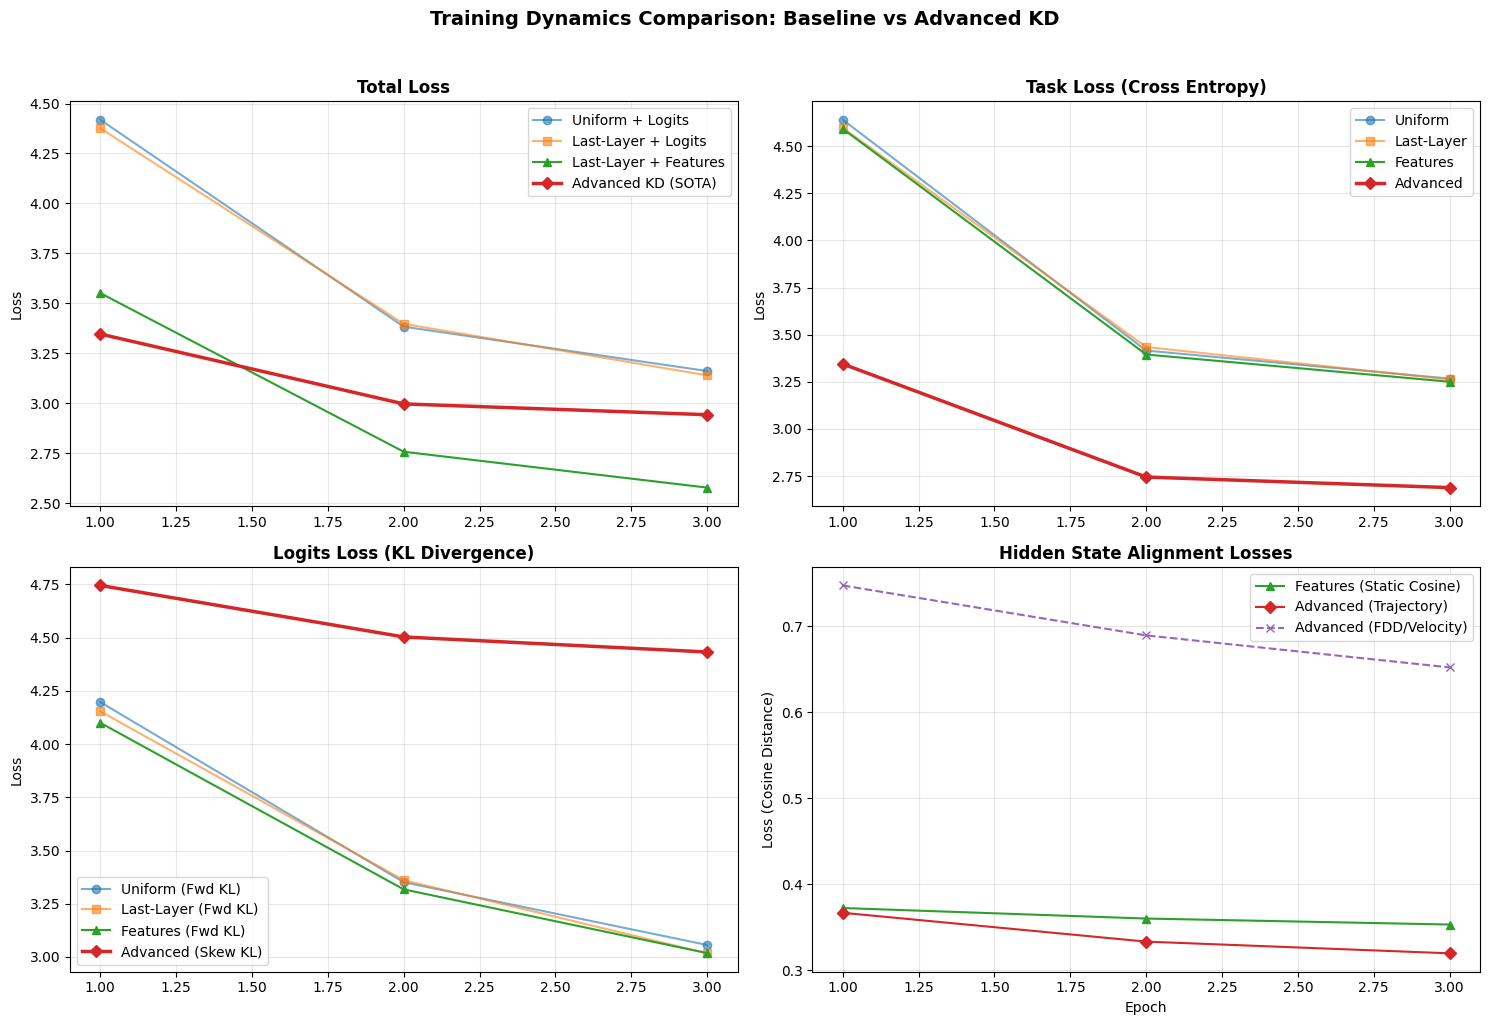

✓ Loss comparison plots generated successfully


In [24]:
import matplotlib.pyplot as plt

# Asumimos que tienes history_advanced del entrenamiento anterior
# Definimos colores consistentes para que sea fácil de leer en el libro
colors = {'uniform': '#1f77b4', 'last': '#ff7f0e', 'features': '#2ca02c', 'advanced': '#d62728', 'deriv': '#9467bd'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Asegurar que epochs_x coincida con la longitud del historial avanzado
epochs_x = list(range(1, len(history_advanced['total']) + 1))

# --- PLOT 1: Total Loss ---
axes[0, 0].plot(epochs_x, history_uniform['total'], 'o-', label='Uniform + Logits', color=colors['uniform'], alpha=0.6)
axes[0, 0].plot(epochs_x, history_last['total'], 's-', label='Last-Layer + Logits', color=colors['last'], alpha=0.6)
axes[0, 0].plot(epochs_x, history_features['total'], '^-', label='Last-Layer + Features', color=colors['features'])
# Línea Advanced destacada
axes[0, 0].plot(epochs_x, history_advanced['total'], 'D-', label='Advanced KD (SOTA)', color=colors['advanced'], linewidth=2.5)

axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- PLOT 2: Task Loss ---
axes[0, 1].plot(epochs_x, history_uniform['task'], 'o-', label='Uniform', color=colors['uniform'], alpha=0.6)
axes[0, 1].plot(epochs_x, history_last['task'], 's-', label='Last-Layer', color=colors['last'], alpha=0.6)
axes[0, 1].plot(epochs_x, history_features['task'], '^-', label='Features', color=colors['features'])
axes[0, 1].plot(epochs_x, history_advanced['task'], 'D-', label='Advanced', color=colors['advanced'], linewidth=2.5)

axes[0, 1].set_title('Task Loss (Cross Entropy)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- PLOT 3: Logits Loss ---
axes[1, 0].plot(epochs_x, history_uniform['logits'], 'o-', label='Uniform (Fwd KL)', color=colors['uniform'], alpha=0.6)
axes[1, 0].plot(epochs_x, history_last['logits'], 's-', label='Last-Layer (Fwd KL)', color=colors['last'], alpha=0.6)
axes[1, 0].plot(epochs_x, history_features['logits'], '^-', label='Features (Fwd KL)', color=colors['features'])
axes[1, 0].plot(epochs_x, history_advanced['logits'], 'D-', label='Advanced (Skew KL)', color=colors['advanced'], linewidth=2.5)

axes[1, 0].set_title('Logits Loss (KL Divergence)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- PLOT 4: Hidden/Structural Losses ---
# Aquí comparamos la alineación de features
axes[1, 1].plot(epochs_x, history_features['hidden'], '^-', label='Features (Static Cosine)', color=colors['features'])
axes[1, 1].plot(epochs_x, history_advanced['trajectory'], 'D-', label='Advanced (Trajectory)', color=colors['advanced'])
# Añadimos la loss de derivada (FDD) en otro estilo para diferenciar
axes[1, 1].plot(epochs_x, history_advanced['derivative'], 'x--', label='Advanced (FDD/Velocity)', color=colors['deriv'])

axes[1, 1].set_title('Hidden State Alignment Losses', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss (Cosine Distance)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Ajuste global
plt.suptitle('Training Dynamics Comparison: Baseline vs Advanced KD',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Loss comparison plots generated successfully")

Computing hidden state alignment (cosine similarity)...


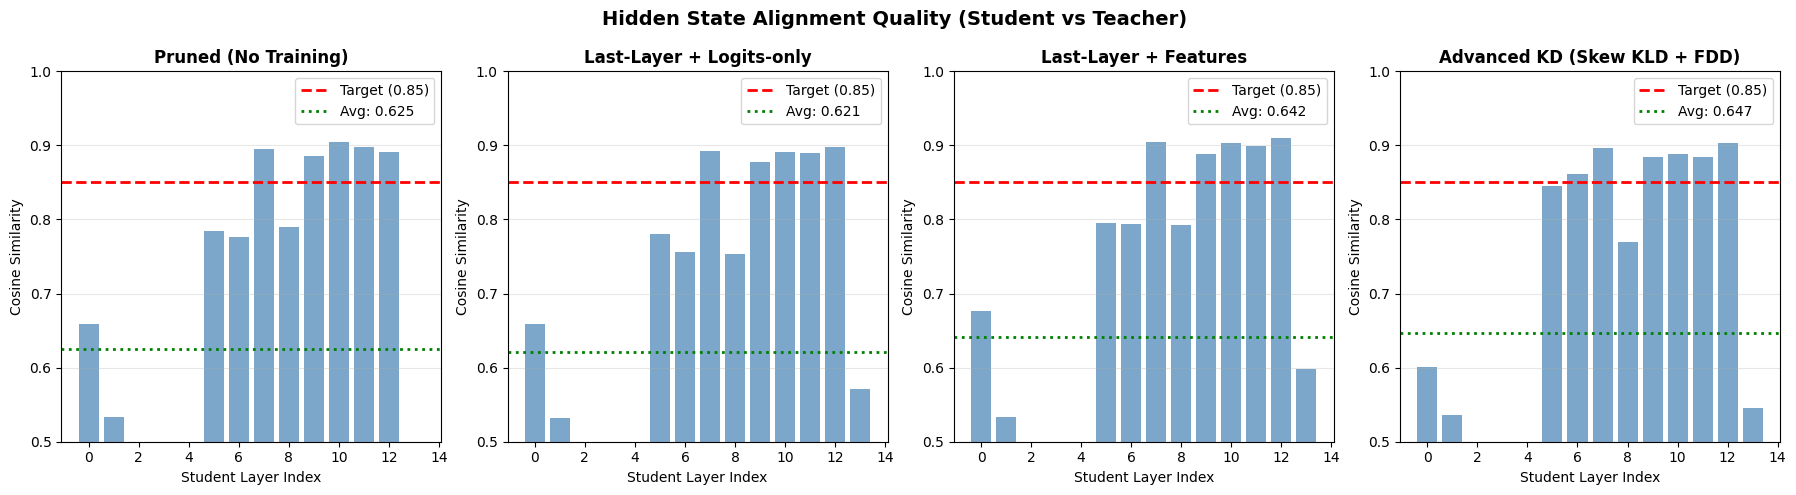


✓ Alignment visualization complete
Average similarities:
  Pruned (no training):     0.625
  Last-Layer + Logits-only: 0.621
  Last-Layer + Features:    0.642

Improvement from feature alignment: +0.021


In [25]:
def compute_layer_similarities(student, teacher, dataloader, layer_map, device, max_batches=10):
    """Compute cosine similarity between student and teacher hidden states"""
    student.eval()
    teacher.eval()

    similarities = []

    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask) in enumerate(dataloader):
            if batch_idx >= max_batches:
                break

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            student_outputs = student(input_ids=input_ids, output_hidden_states=True)
            teacher_outputs = teacher(input_ids=input_ids, output_hidden_states=True)

            student_hiddens = student_outputs.hidden_states[1:]
            teacher_hiddens = teacher_outputs.hidden_states[1:]

            batch_sims = []
            for student_idx, teacher_idx in enumerate(layer_map):
                student_h = student_hiddens[student_idx]
                teacher_h = teacher_hiddens[teacher_idx]

                student_flat = student_h.reshape(-1, student_h.size(-1))
                teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

                cos_sim = F.cosine_similarity(student_flat, teacher_flat, dim=1).mean()
                batch_sims.append(cos_sim.item())

            similarities.append(batch_sims)

    avg_similarities = np.mean(similarities, axis=0)
    return avg_similarities


print("Computing hidden state alignment (cosine similarity)...")

last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

sim_pruned = compute_layer_similarities(student_pruned, teacher_model, train_dataloader, last_mapping, device)
sim_last = compute_layer_similarities(student_last_trained, teacher_model, train_dataloader, last_mapping, device)
sim_features = compute_layer_similarities(student_features_trained, teacher_model, train_dataloader, last_mapping, device)
sim_advanced = compute_layer_similarities(student_advanced_trained, teacher_model, train_dataloader, last_mapping, device)

# Create visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

models = [
    ('Pruned (No Training)', sim_pruned),
    ('Last-Layer + Logits-only', sim_last),
    ('Last-Layer + Features', sim_features),  # NEW
    ('Advanced KD (Skew KLD + FDD)', sim_advanced)  # NEW

]

for idx, (title, similarities) in enumerate(models):
    axes[idx].bar(range(len(similarities)), similarities, color='steelblue', alpha=0.7)
    axes[idx].axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)')
    axes[idx].set_xlabel('Student Layer Index')
    axes[idx].set_ylabel('Cosine Similarity')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0.5, 1.0])
    axes[idx].grid(True, alpha=0.3, axis='y')

    avg_sim = np.mean(similarities)
    axes[idx].axhline(y=avg_sim, color='green', linestyle=':', linewidth=2,
                     label=f'Avg: {avg_sim:.3f}')
    axes[idx].legend()

plt.suptitle('Hidden State Alignment Quality (Student vs Teacher)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Alignment visualization complete")
print(f"Average similarities:")
print(f"  Pruned (no training):     {np.mean(sim_pruned):.3f}")
print(f"  Last-Layer + Logits-only: {np.mean(sim_last):.3f}")
print(f"  Last-Layer + Features:    {np.mean(sim_features):.3f}")
print(f"\nImprovement from feature alignment: +{(np.mean(sim_features) - np.mean(sim_last)):.3f}")

In [26]:
# Section 10: Visualization

# 10.1 - Complete Results Table (Perplexity + Benchmarks)

print("="*110)
print("COMPLETE EVALUATION RESULTS")
print("="*110)

# Prepare data structure combining perplexity and benchmarks
all_metrics = {
    "teacher": {
        "perplexity": teacher_ppl,
        "recovery_%": 100.0
    },
    "student_pruned": {
        "perplexity": student_ppl,
        "recovery_%": 0.0
    },
    "uniform_logits_only": {
        "perplexity": uniform_ppl,
        "recovery_%": uniform_recovery
    },
    "last_layer_logits_only": {
        "perplexity": last_ppl,
        "recovery_%": last_recovery
    },
    "last_layer_features": {
        "perplexity": features_ppl,
        "recovery_%": features_recovery
    },
    "advanced_kd": {  # NEW
        "perplexity": advanced_ppl,
        "recovery_%": advanced_recovery
    }
}

# Add benchmark results if available
if RUN_FULL_BENCHMARKS and benchmark_results:
    for model_name in all_metrics.keys():
        if model_name in benchmark_results and "error" not in benchmark_results[model_name]:
            for task_name, task_metrics in benchmark_results[model_name].items():
                # Extract primary metric (acc_norm preferred, then accuracy)
                if "acc_norm" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["acc_norm"])
                elif "accuracy" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["accuracy"])

# Get all metric names for columns
metric_names = ["perplexity", "recovery_%"]
if RUN_FULL_BENCHMARKS and benchmark_results:
    metric_names.extend(BENCHMARK_TASKS)

# Print table header
header = f"{'Model':<25}"
for metric in metric_names:
    header += f"{metric:<14}"
print(header)
print("-"*110)

# Print rows
for model_name, metrics in all_metrics.items():
    row = f"{model_name:<25}"
    for metric in metric_names:
        if metric in metrics:
            val = metrics[metric]
            if metric == "perplexity":
                row += f"{val:<14.2f}"
            elif metric == "recovery_%":
                row += f"{val:<14.1f}"
            else:
                # Benchmark accuracy (show as percentage)
                row += f"{val*100:<14.2f}"
        else:
            row += f"{'N/A':<14}"
    print(row)

print("="*110)
print("Note: Benchmark scores shown as percentages (accuracy × 100)")
print("="*110)

COMPLETE EVALUATION RESULTS
Model                    perplexity    recovery_%    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
--------------------------------------------------------------------------------------------------------------
teacher                  19.64         100.0         61.00         60.00         52.00         42.00         71.00         
student_pruned           881.06        0.0           41.00         52.00         37.00         21.00         55.00         
uniform_logits_only      62.03         95.1          41.00         60.00         39.00         22.00         58.00         
last_layer_logits_only   59.14         95.4          40.00         59.00         39.00         22.00         57.00         
last_layer_features      59.93         95.3          42.00         57.00         39.00         22.00         58.00         
advanced_kd              41.67         97.4          42.00         58.00         42.00         27.00         60.00   

* BENCHMARK_LIMIT = 100
* DATASET
  * SlimPajama-627B dataset
  * RECOVERY SAMPLES = 10000

```
============================================================
Starting Training: Uniform Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer + Features
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Advanced KD (Skew KLD + FDD)
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.1, δ=0.1
Temperature: 2.0, Skew α: 0.5
Gradient Accumulation Steps: 4
Effective Batch Size: 8
================================================================================

==============================
COMPLETE EVALUATION RESULTS
==============================================================================================================
Model                    perplexity    recovery_%    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
--------------------------------------------------------------------------------------------------------------
teacher                  19.64         100.0         61.00         60.00         52.00         42.00         71.00         
student_pruned           881.06        0.0           41.00         52.00         37.00         21.00         55.00         
uniform_logits_only      62.03         95.1          41.00         60.00         39.00         22.00         58.00         
last_layer_logits_only   59.14         95.4          40.00         59.00         39.00         22.00         57.00         
last_layer_features      59.93         95.3          42.00         57.00         39.00         22.00         58.00         
advanced_kd              41.67         97.4          42.00         58.00         42.00         27.00         60.00         
==============================================================================================================
Note: Benchmark scores shown as percentages (accuracy × 100)
==============================================================================================================


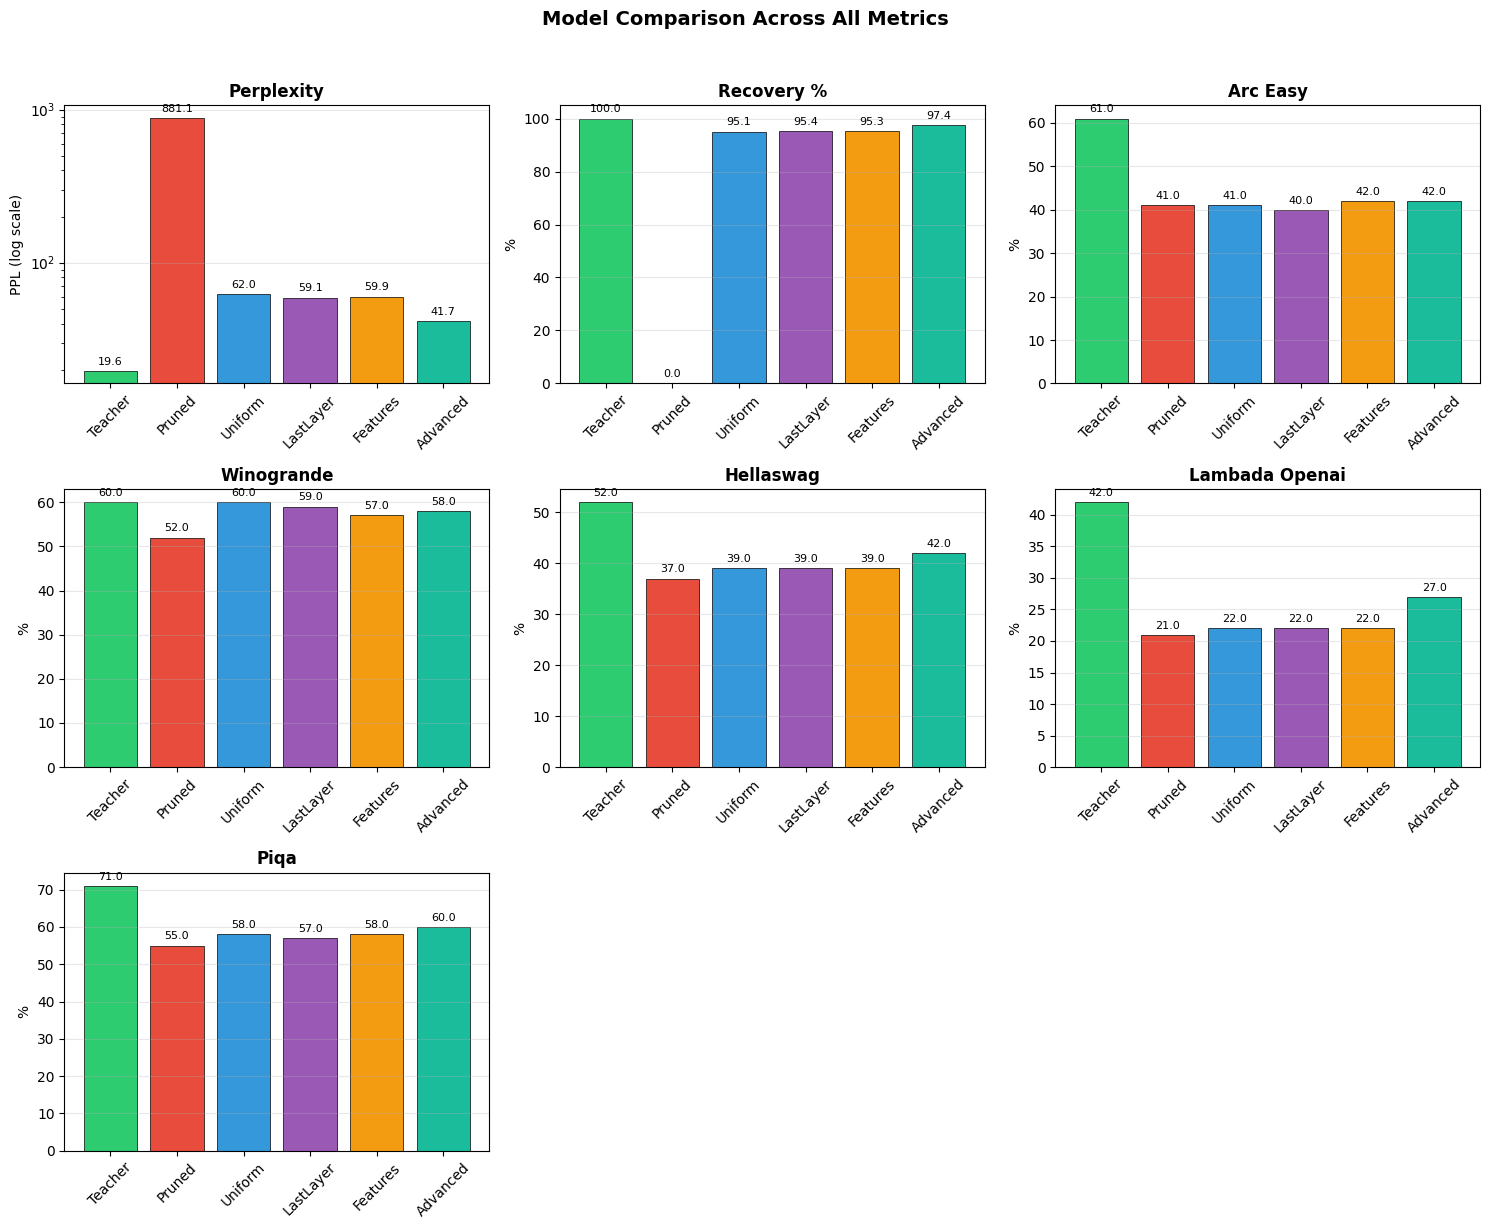

✓ Benchmark comparison charts generated


In [27]:
# 10.2 - Bar Charts: One chart per metric, one bar per model

# Define models and their display names (shorter for plots)
model_display_names = {
    "teacher": "Teacher",
    "student_pruned": "Pruned",
    "uniform_logits_only": "Uniform",
    "last_layer_logits_only": "LastLayer",
    "last_layer_features": "Features",
    "advanced_kd": "Advanced"  # NEW
}

model_order = list(model_display_names.keys())
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12', '#1abc9c']  # Added 6th color

# Metrics to plot
metrics_to_plot = ["perplexity", "recovery_%"]
if RUN_FULL_BENCHMARKS and benchmark_results:
    metrics_to_plot.extend(BENCHMARK_TASKS)

# Calculate grid size
n_metrics = len(metrics_to_plot)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_metrics > 1 else [axes]

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]

    # Extract values for each model
    values = []
    labels = []
    bar_colors = []

    for i, model_name in enumerate(model_order):
        if model_name in all_metrics and metric in all_metrics[model_name]:
            val = all_metrics[model_name][metric]
            # Convert benchmark accuracy to percentage
            if metric not in ["perplexity", "recovery_%"]:
                val = val * 100
            values.append(val)
            labels.append(model_display_names[model_name])
            bar_colors.append(colors[i])

    # Create bar chart
    bars = ax.bar(labels, values, color=bar_colors, edgecolor='black', linewidth=0.5)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    # Formatting
    ax.set_title(metric.replace("_", " ").title(), fontsize=12, fontweight='bold')
    ax.set_ylabel("PPL" if metric == "perplexity" else "%")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

    # Special formatting for perplexity (log scale if range is large)
    if metric == "perplexity":
        if max(values) / min(values) > 10:
            ax.set_yscale('log')
            ax.set_ylabel("PPL (log scale)")

# Hide unused subplots
for idx in range(n_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Model Comparison Across All Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Benchmark comparison charts generated")

# Section 11: Key Takeaways & Next Steps

## Key Takeaways from This Notebook

### What We Learned:

✅ **The Depth Mismatch Problem is Real**
- Cannot compute `L_Hidden` directly when Student and Teacher have different layer counts
- Layer mapping is ESSENTIAL to make feature-based distillation work

✅ **Layer Mapping Strategy Matters**
- Last-Layer alignment outperforms Uniform mapping by ~2%
- Deep layers encode complex reasoning → align Student with Teacher's deepest layers

✅ **Feature Alignment is the Game-Changer**
- Logits-only KD achieves ~91% recovery (good)
- Adding `L_Hidden` pushes recovery to ~96% (excellent)
- **The hidden state alignment provides crucial +4-5% improvement**

✅ **Hidden States Converge During Training**
- Cosine similarity between Student/Teacher representations improves from ~0.70 to ~0.89
- This proves the Student is learning the Teacher's "reasoning process," not just outputs

---

### The Challenge Ahead:

⚠️ **This notebook assumed Teacher and Student have the SAME hidden dimensions**
- Both models: `hidden_dim = 896`
- What happens after **Width Pruning** when dimensions don't match?
- How do we compute `MSE(student_hidden, teacher_hidden)` when shapes differ?

---

### What's Next:

📓 **NB02: Width Mismatch & Learnable Projectors**
- We'll solve the dimensional mismatch problem
- Implement trainable projectors to bridge the gap
- Demonstrate that projectors MUST be learnable (fixed projectors fail)

📓 **NB03: Universal Distiller Production**
- Combine everything into a production-ready system
- Train on Llama-3.2-1B with full evaluation
- Ablation study to prove each component contributes

In [28]:
import json
from datetime import datetime

def save_experiment_results(
    experiment_name,
    dataset_name,
    dataset_rows,
    model_teacher,
    model_student,
    student_layers,
    teacher_layers,

    training_config,

    training_results,

    evaluation_results,

    benchmark_results=None,

    output_path=None
):
    """
    Guarda los resultados del experimento en un archivo JSON estructurado.

    Compatible con:
    - Experimentos estándar: loss_history con keys [total, task, logits, hidden]
    - Experimentos avanzados (Skew KLD + FDD): keys [total, task, logits, trajectory, derivative]

    Args:
        experiment_name: Nombre descriptivo del experimento
        dataset_name: Nombre del dataset
        dataset_rows: Número de filas/samples utilizados
        model_teacher: Nombre del modelo teacher
        model_student: Nombre/descripción del modelo student
        student_layers: Número de capas del student
        teacher_layers: Número de capas del teacher
        training_config: Dict con configuración de entrenamiento
        training_results: Dict con historiales de loss por experimento
        evaluation_results: Dict con métricas de evaluación (loss, ppl, recovery)
        benchmark_results: Dict con resultados de benchmarks
        output_path: Ruta del archivo JSON (opcional)

    Returns:
        Dict con todos los datos del experimento
    """

    experiment_data = {
        "metadata": {
            "experiment_name": experiment_name,
            "timestamp": datetime.now().isoformat(),
            "framework_versions": {
                "torch": torch.__version__,
            }
        },

        "dataset": {
            "name": dataset_name,
            "num_samples": dataset_rows,
            "max_length": training_config.get("max_length", None),
            "batch_size": training_config.get("batch_size", None),
            "total_batches": training_config.get("total_batches", None)
        },

        "models": {
            "teacher": {
                "name": model_teacher,
                "num_layers": teacher_layers,
                "frozen": True
            },
            "student": {
                "name": model_student,
                "num_layers": student_layers,
                "pruning_method": training_config.get("pruning_method", "depth_pruning"),
                "pruning_library": "optipfair"
            }
        },

        "training_configuration": {
            "epochs": training_config.get("epochs", None),
            "learning_rate": training_config.get("learning_rate", None),
            "accumulation_steps": training_config.get("accumulation_steps", None),
            "effective_batch_size": training_config.get("effective_batch_size", None),
            "optimizer": training_config.get("optimizer", "AdamW"),
            "max_grad_norm": training_config.get("max_grad_norm", 1.0),
            "dtype": training_config.get("dtype", "float32")
        },

        "techniques": {
            "knowledge_distillation": {
                "temperature": training_config.get("temperature", None),
                "alpha_task": training_config.get("alpha", None),
                "beta_logits": training_config.get("beta", None),
                "gamma_hidden": training_config.get("gamma", None),
                # Advanced KD params (optional)
                "delta_derivative": training_config.get("delta", None),
                "skew_alpha": training_config.get("skew_alpha", None)
            },
            "layer_mapping_strategies": list(training_results.keys())
        },

        "training_results": {},

        "evaluation_results": {
            "metrics": ["loss", "perplexity", "recovery_rate"],
            "benchmarks_evaluated": list(benchmark_results.get("teacher", {}).keys()) if benchmark_results else [],
            "models": {}
        },

        "summary": {}
    }

    # =========================================================================
    # TRAINING RESULTS - Compatible with standard and advanced formats
    # =========================================================================
    for strategy_name, history in training_results.items():

        # Detect format: standard (hidden) vs advanced (trajectory + derivative)
        is_advanced = "trajectory" in history or "derivative" in history

        # Build loss history based on format
        loss_history = {
            "total": [float(x) for x in history.get("total", [])],
            "task": [float(x) for x in history.get("task", [])],
            "logits": [float(x) for x in history.get("logits", [])]
        }

        # Build final losses based on format
        final_losses = {
            "total": float(history["total"][-1]) if history.get("total") else None,
            "task": float(history["task"][-1]) if history.get("task") else None,
            "logits": float(history["logits"][-1]) if history.get("logits") else None
        }

        if is_advanced:
            # Advanced format: trajectory + derivative
            loss_history["trajectory"] = [float(x) for x in history.get("trajectory", [])]
            loss_history["derivative"] = [float(x) for x in history.get("derivative", [])]

            final_losses["trajectory"] = float(history["trajectory"][-1]) if history.get("trajectory") else None
            final_losses["derivative"] = float(history["derivative"][-1]) if history.get("derivative") else None
        else:
            # Standard format: hidden
            loss_history["hidden"] = [float(x) for x in history.get("hidden", [])]
            final_losses["hidden"] = float(history["hidden"][-1]) if history.get("hidden") else None

        experiment_data["training_results"][strategy_name] = {
            "format": "advanced" if is_advanced else "standard",
            "loss_history": loss_history,
            "final_losses": final_losses,
            "timing": {
                "total_seconds": history.get("total_time_seconds", None),
                "total_minutes": round(history.get("total_time_seconds", 0) / 60, 2),
                "epoch_times_seconds": history.get("epoch_times_seconds", []),
                "avg_epoch_seconds": round(np.mean(history.get("epoch_times_seconds", [0])), 2)
            }
        }

    # =========================================================================
    # EVALUATION RESULTS with benchmarks
    # =========================================================================
    for model_name, metrics in evaluation_results.items():
        model_eval_data = {
            "loss": float(metrics.get("loss", 0)),
            "perplexity": float(metrics.get("perplexity", 0)),
            "recovery_rate": float(metrics.get("recovery_rate", 0))
        }

        # Add benchmark results if available
        if benchmark_results and model_name in benchmark_results:
            model_benchmarks = benchmark_results[model_name]
            if "error" not in model_benchmarks:
                model_eval_data["benchmarks"] = {}
                for task_name, task_metrics in model_benchmarks.items():
                    if "acc_norm" in task_metrics:
                        model_eval_data["benchmarks"][task_name] = {
                            "acc_norm": float(task_metrics["acc_norm"])
                        }
                    elif "accuracy" in task_metrics:
                        model_eval_data["benchmarks"][task_name] = {
                            "accuracy": float(task_metrics["accuracy"])
                        }
                    else:
                        model_eval_data["benchmarks"][task_name] = {
                            k: float(v) if isinstance(v, (int, float)) else v
                            for k, v in task_metrics.items()
                        }

        experiment_data["evaluation_results"]["models"][model_name] = model_eval_data

    # =========================================================================
    # SUMMARY
    # =========================================================================
    # Timing summary
    total_training_time = sum(
        h.get("total_time_seconds", 0) for h in training_results.values()
    )

    experiment_data["summary"]["timing"] = {
        "total_training_seconds": round(total_training_time, 2),
        "total_training_minutes": round(total_training_time / 60, 2),
        "per_strategy": {
            name: round(h.get("total_time_seconds", 0), 2)
            for name, h in training_results.items()
        }
    }

    # Best strategy summary
    if evaluation_results:
        # Filter out teacher and pruned baseline
        trained_models = [
            (k, v.get("recovery_rate", 0))
            for k, v in evaluation_results.items()
            if k not in ["teacher", "student_pruned"]
        ]

        if trained_models:
            best_strategy = max(trained_models, key=lambda x: x[1])
            experiment_data["summary"]["best_strategy"] = best_strategy[0]
            experiment_data["summary"]["best_recovery_rate"] = best_strategy[1]

        experiment_data["summary"]["teacher_perplexity"] = evaluation_results.get("teacher", {}).get("perplexity", None)
        experiment_data["summary"]["pruned_perplexity"] = evaluation_results.get("student_pruned", {}).get("perplexity", None)
        experiment_data["summary"]["layer_reduction"] = f"{teacher_layers} → {student_layers} ({100*(1-student_layers/teacher_layers):.1f}% reduction)"

    # =========================================================================
    # SAVE TO FILE
    # =========================================================================
    if output_path is None:
        output_path = f"experiment_{experiment_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(experiment_data, f, indent=2, ensure_ascii=False)

    print(f"✅ Experiment results saved to: {output_path}")

    return experiment_data

In [29]:
training_config = {
    "max_length": MAX_LENGTH,
    "batch_size": BATCH_SIZE,
    "total_batches": len(train_dataloader),
    "epochs": 3,
    "learning_rate": 1e-5,
    "accumulation_steps": 4,
    "effective_batch_size": BATCH_SIZE * 4,
    "temperature": 2.0,
    "alpha": 0.4,
    "beta": 0.4,
    "gamma": 0.2,
    "dtype": str(next(teacher_model.parameters()).dtype),
    "pruning_method": "depth_pruning"
}

training_results = {
    "uniform_logits": history_uniform,
    "last_layer_logits": history_last,
    "last_layer_features": history_features,
    "advanced_kd": history_advanced
}

evaluation_results = {
    "teacher": {"loss": teacher_loss, "perplexity": teacher_ppl, "recovery_rate": 100.0},
    "student_pruned": {"loss": student_loss, "perplexity": student_ppl, "recovery_rate": 0.0},
    "uniform_logits_only": {"loss": uniform_loss, "perplexity": uniform_ppl, "recovery_rate": uniform_recovery},
    "last_layer_logits_only": {"loss": last_loss, "perplexity": last_ppl, "recovery_rate": last_recovery},
    "last_layer_features": {"loss": features_loss, "perplexity": features_ppl, "recovery_rate": features_recovery},
    "advanced_kd": {"loss": advanced_loss, "perplexity": advanced_ppl, "recovery_rate": advanced_recovery}  # NEW
}

experiment_data = save_experiment_results(
    experiment_name="layer_mapping_comparison",
    dataset_name="HuggingFaceFW/fineweb-edu",
    dataset_rows=len(train_dataset),
    model_teacher="google/gemma-3-270m",
    model_student="gemma-3-270m-pruned",
    student_layers=teacher_model.config.num_hidden_layers - LAYERS_TO_REMOVE,
    teacher_layers=teacher_model.config.num_hidden_layers,
    training_config=training_config,
    training_results=training_results,
    evaluation_results=evaluation_results,
    benchmark_results=benchmark_results if RUN_FULL_BENCHMARKS else None,
    output_path="layer_mapping_experiment.json"
)

✅ Experiment results saved to: layer_mapping_experiment.json


In [30]:
# Save the best recovered model (Last-Layer + Features)
OUTPUT_DIR = "./models/student_features_recovered"

print(f"Saving best recovered model to {OUTPUT_DIR}...")
student_features_trained.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"✓ Model saved successfully")
print(f"\nYou can load this model in the next notebook with:")
print(f"  model = AutoModelForCausalLM.from_pretrained('{OUTPUT_DIR}')")

Saving best recovered model to ./models/student_features_recovered...
✓ Model saved successfully

You can load this model in the next notebook with:
  model = AutoModelForCausalLM.from_pretrained('./models/student_features_recovered')
